# FMRI Classifier

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.dataset.kay import load_dataset
from src.utils.util import prepare_fmri_data

from src.ml.test import test_model
from src.ml.train import train_model
from src.ml.model import FMRIClassifier
from src.ml.config import FMRIClassifierConfig
from src.ml.dataset import FMRIDataset, create_weighted_sampler
from src.ml.utils import plot_loss_acc_curves, generate_score_report

In [ ]:
%matplotlib inline

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

title_size = 16
params = {
    "legend.fontsize": 14,
    "axes.labelsize": title_size - 2,
    "axes.titlesize": title_size,
    "xtick.labelsize": title_size - 4,
    "ytick.labelsize": title_size - 4,
    "axes.titlepad": 1.5 * title_size,
}

plt.rcParams.update(params)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [ ]:
config = FMRIClassifierConfig()

## Load Data

In [ ]:
all_data = load_dataset(data_path="./../data/")

In [ ]:
x_train, y_train = prepare_fmri_data(
    all_data=all_data,
    data_subset="train",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)


x_test, y_test = prepare_fmri_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1593, 8427), (1593,), (114, 8427), (114,))

In [ ]:
class2idx = {k: i for i, k in enumerate(np.unique(y_train))}
idx2class = {v: k for k, v in class2idx.items()}

## Create Dataset and Dataloader

In [ ]:
train_dataset = FMRIDataset(x_data=x_train, y_data=y_train, class2idx=class2idx)
test_dataset = FMRIDataset(x_data=x_test, y_data=y_test, class2idx=class2idx)


weighted_sampler = create_weighted_sampler(y_train, class2idx)


train_loader = DataLoader(
    dataset=train_dataset,
    shuffle=False,
    batch_size=config.batch_size,
    sampler=weighted_sampler,
)

test_loader = DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=config.batch_size
)

## Initialize Model

In [ ]:
model = FMRIClassifier(num_features=x_train.shape[1], num_classes=len(class2idx))
model.to(device)

epochs = config.epochs
criterion = nn.CrossEntropyLoss()  # weight=class_weights.to(device)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

## Train Model

In [11]:
loss_stats, acc_stats = train_model(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_model_path="./../models/fmri_classifier/fmri_classifier_model.pth",
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01/50: | Train Loss: 0.94736 | Val Loss: 1.03975 | Train Acc: 56.000% | Val Acc: 38.000%
Epoch 02/50: | Train Loss: 0.74161 | Val Loss: 1.11034 | Train Acc: 68.769% | Val Acc: 37.000%
Epoch 03/50: | Train Loss: 0.49557 | Val Loss: 1.00746 | Train Acc: 79.154% | Val Acc: 46.000%
Epoch 04/50: | Train Loss: 0.34522 | Val Loss: 0.99719 | Train Acc: 86.692% | Val Acc: 52.000%
Epoch 05/50: | Train Loss: 0.28418 | Val Loss: 0.98422 | Train Acc: 88.769% | Val Acc: 54.000%
Epoch 06/50: | Train Loss: 0.20155 | Val Loss: 1.00613 | Train Acc: 93.154% | Val Acc: 56.000%
Epoch 07/50: | Train Loss: 0.17800 | Val Loss: 1.04622 | Train Acc: 93.538% | Val Acc: 54.000%
Epoch 08/50: | Train Loss: 0.11021 | Val Loss: 1.14345 | Train Acc: 96.769% | Val Acc: 55.000%
Epoch 09/50: | Train Loss: 0.11000 | Val Loss: 1.07688 | Train Acc: 96.000% | Val Acc: 54.000%
Epoch 10/50: | Train Loss: 0.10128 | Val Loss: 1.29134 | Train Acc: 97.308% | Val Acc: 54.000%
Epoch 11/50: | Train Loss: 0.08509 | Val Loss: 1.0

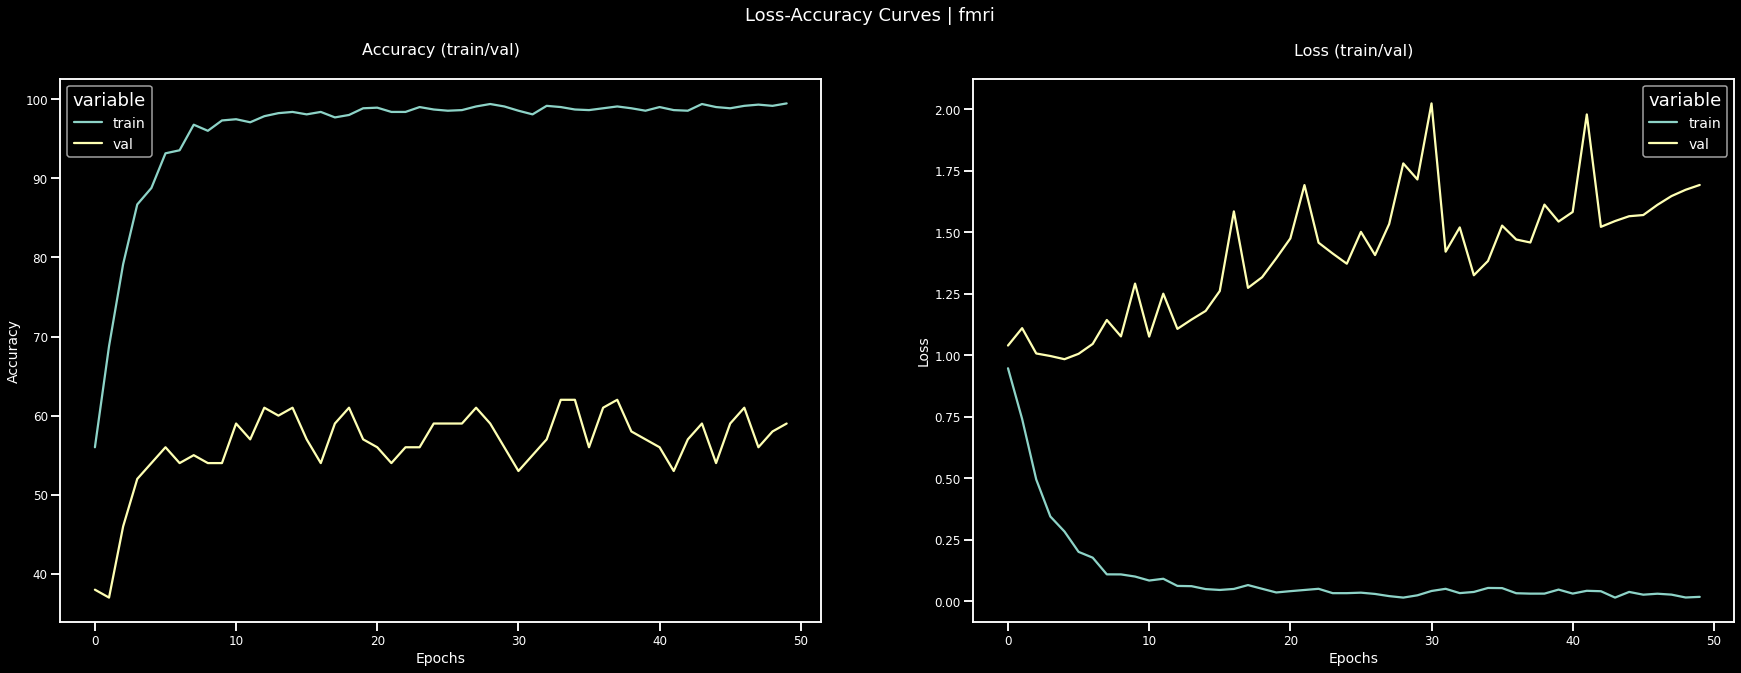

In [12]:
plot_loss_acc_curves(loss_stats, acc_stats, model_name="fmri")

## Test Model

In [13]:
y_true_list, y_pred_list = test_model(model, test_loader, device)

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report | fmri:

              precision    recall  f1-score   support

           0       0.74      0.46      0.57        54
           1       0.55      0.78      0.64        50
           2       0.33      0.30      0.32        10

    accuracy                           0.59       114
   macro avg       0.54      0.51      0.51       114
weighted avg       0.62      0.59      0.58       114






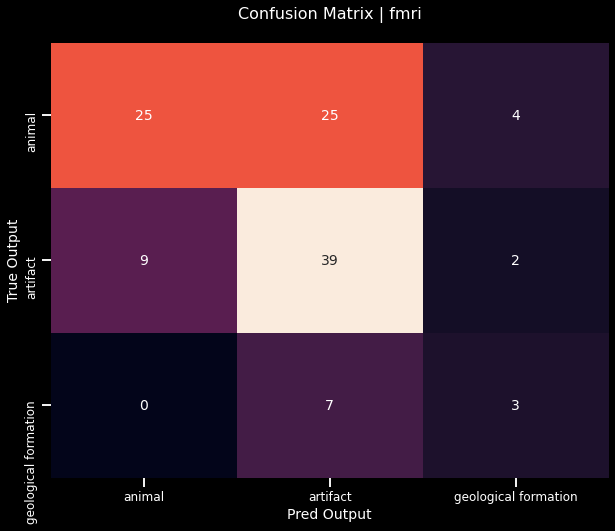

In [14]:
generate_score_report(
    y_true=y_true_list, y_pred=y_pred_list, idx2class=idx2class, model_name="fmri"
)